In [1]:
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score

K = 2, Silhouette Score = 0.1272
K = 3, Silhouette Score = 0.1134
K = 4, Silhouette Score = 0.1112
K = 5, Silhouette Score = 0.1144
K = 6, Silhouette Score = 0.1166
K = 7, Silhouette Score = 0.1222
K = 8, Silhouette Score = 0.1145
K = 9, Silhouette Score = 0.1215


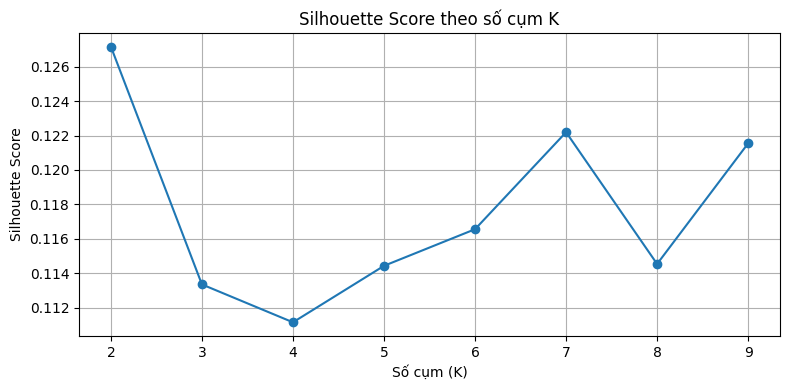

✅ Số cụm tốt nhất: 2
✅ Đã lưu kết quả phân cụm vào file feature_vectors_clustered.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# ---- STEP 1: Load dữ liệu ----
df = pd.read_csv("feature_vectors_expanded.csv")

# ---- STEP 2: Lựa chọn feature (loại bỏ những cột không phù hợp để phân cụm) ----
features = df.drop(columns=['userid', 'courseid', 'max_time_diff', 'forum_access', 'quiz_access', 'hvp_access'])

# ---- STEP 3: Chuẩn hoá dữ liệu với StandardScaler ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# ---- STEP 4: Tìm số cụm tối ưu bằng Silhouette Score ----
sil_scores = []
k_range = range(2, 10)  # Chỉ xét K=2 và K=3

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"K = {k}, Silhouette Score = {score:.4f}")

# ---- STEP 5: Vẽ biểu đồ Silhouette Score theo K ----
plt.figure(figsize=(8, 4))
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score theo số cụm K")
plt.xlabel("Số cụm (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- STEP 6: Chọn số cụm tốt nhất ----
best_k = k_range[sil_scores.index(max(sil_scores))]
print(f"✅ Số cụm tốt nhất: {best_k}")

# ---- STEP 7: Phân cụm với số cụm tốt nhất ----
final_model = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels = final_model.fit_predict(X_scaled)

# ---- STEP 8: Gắn nhãn cụm vào DataFrame và lưu ra file mới ----
df['cluster'] = cluster_labels
df.to_csv("feature_vectors_clustered.csv", index=False)
print("✅ Đã lưu kết quả phân cụm vào file feature_vectors_clustered.csv")

In [4]:
def build_state(user_log_summary):
    """
    Xây dựng trạng thái hiện tại của người học từ các thống kê log.

    Args:
        user_log_summary (dict): Dictionary chứa dữ liệu thống kê từ log, ví dụ:
            {
              'cluster': 1,
              'last_type': 'quiz',         # 'quiz', 'resource', 'hvp'
              'last_result': 'fail',       # 'pass' / 'fail' / 'done' / 'none'
              'completion_rate': 0.8,
              'pass_rate': 0.3,
              'low_score_quiz_count': 3
            }

    Returns:
        tuple: Trạng thái được biểu diễn dạng tuple (dùng để tra Q-Table)
    """

    cluster = user_log_summary.get('cluster', 0)

    last_type = user_log_summary.get('last_type', 'none')  # 'quiz', 'resource', 'hvp', 'none'
    last_result = user_log_summary.get('last_result', 'none')  # 'pass', 'fail', 'done', 'none'

    # Rút gọn completion_rate thành nhị phân hoặc nhị phân hoá mượt hơn
    completion_rate = user_log_summary.get('completion_rate', 0.0)
    if completion_rate >= 0.8:
        comp_cat = 'high'
    elif completion_rate >= 0.5:
        comp_cat = 'medium'
    else:
        comp_cat = 'low'

    # Rút gọn pass_rate tương tự
    pass_rate = user_log_summary.get('pass_rate', 0.0)
    if pass_rate >= 0.7:
        pass_cat = 'high'
    elif pass_rate >= 0.4:
        pass_cat = 'medium'
    else:
        pass_cat = 'low'

    # Nhóm số lượng quiz trượt thành các mức
    low_score_quiz_count = user_log_summary.get('low_score_quiz_count', 0)
    if low_score_quiz_count == 0:
        quiz_status = 'none'
    elif low_score_quiz_count <= 2:
        quiz_status = 'few'
    else:
        quiz_status = 'many'

    # Trả về một tuple – rất phù hợp làm key cho Q-Table
    return (cluster, last_type, last_result, comp_cat, pass_cat, quiz_status)

In [10]:
import pandas as pd
import random

# --- STEP 1: Đọc file log ---
df = pd.read_csv("user_log_summary.csv")

# Lấy 2 dòng cuối cùng: dòng trước và dòng mới nhất
prev_row = df.iloc[-2]
curr_row = df.iloc[-1]

# --- STEP 2: Chuyển thành state ---
def build_state(row):
    cluster = int(row['cluster'])
    last_type = row['last_type']
    last_result = row['last_result']
    
    completion_rate = float(row['completion_rate'])
    if completion_rate >= 0.8:
        comp_cat = 'high'
    elif completion_rate >= 0.5:
        comp_cat = 'medium'
    else:
        comp_cat = 'low'

    pass_rate = float(row['pass_rate'])
    if pass_rate >= 0.7:
        pass_cat = 'high'
    elif pass_rate >= 0.4:
        pass_cat = 'medium'
    else:
        pass_cat = 'low'

    low_score_quiz_count = int(row['low_score_quiz_count'])
    if low_score_quiz_count == 0:
        quiz_status = 'none'
    elif low_score_quiz_count <= 2:
        quiz_status = 'few'
    else:
        quiz_status = 'many'

    return (cluster, last_type, last_result, comp_cat, pass_cat, quiz_status)

state_before = build_state(prev_row)
state_after = build_state(curr_row)

# --- STEP 3: Load Q-table ---
q_table = pd.read_csv("q_table.csv")

# Biến q_table từ DataFrame về dict
def load_qtable_from_df(df_q):
    q = {}
    for _, row in df_q.iterrows():
        state = tuple(row[['cluster', 'last_type', 'last_result', 'completion_rate', 'pass_rate', 'quiz_status']])
        q[state] = {
            'do_quiz': row['do_quiz'],
            'watch_video': row['watch_video'],
            'read_pdf': row['read_pdf']
        }
    return q

q_dict = load_qtable_from_df(q_table)
actions = ['do_quiz', 'watch_video', 'read_pdf']

# --- STEP 4: Lấy hành động trước đó ---
# Ta giả định action được thực hiện tương ứng với last_type ở state hiện tại
mapping = {
    'quiz': 'do_quiz',
    'hvp': 'watch_video',
    'resource': 'read_pdf'
}
action_taken = mapping.get(curr_row['last_type'], 'read_pdf')  # fallback

# --- STEP 5: Cập nhật Q-table ---
def update_q_table(q, state, action, reward, next_state, alpha=0.1, gamma=0.9):
    old_value = q[state][action]
    next_max = max(q[next_state].values())
    new_value = old_value + alpha * (reward + gamma * next_max - old_value)
    q[state][action] = new_value

# Tính reward (bạn có thể cải tiến sau)
reward = 1 if curr_row['last_result'] == 'pass' else -1

update_q_table(q_dict, state_before, action_taken, reward, state_after)

# --- STEP 6: Gợi ý hành động tiếp theo ---
def choose_action(q_table, state, actions, epsilon=0.0):
    if random.random() < epsilon:
        return random.choice(actions)
    return max(q_table[state], key=q_table[state].get)

next_action = choose_action(q_dict, state_after, actions, epsilon=0.0)
q_value = q_dict[state_after][next_action]
print(f"🤖 Gợi ý hành động tiếp theo: {next_action} (Q-value = {q_value:.4f})")

# --- STEP 7: Ghi lại Q-table mới ---
def save_q_table_dict(q_dict, actions, filename="q_table.csv"):
    rows = []
    for state, action_values in q_dict.items():
        row = list(state)
        for action in actions:
            row.append(action_values[action])
        rows.append(row)
    columns = ['cluster', 'last_type', 'last_result', 'completion_rate', 'pass_rate', 'quiz_status'] + actions
    pd.DataFrame(rows, columns=columns).to_csv(filename, index=False)

save_q_table_dict(q_dict, actions)

🤖 Gợi ý hành động tiếp theo: do_quiz (Q-value = 0.0000)
